In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## The CNN/DailyMail
- The dataset includes approximately 300,000 pairs of news articles and their summaries, created from bullet points attached by CNN and DailyMail to their articles.

In [5]:
!pip install transformers

In [6]:
!pip install datasets

In [7]:
import torch

# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB


In [8]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

print(f"Features: {dataset['train'].column_names}")

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Features: ['article', 'highlights', 'id']


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [10]:
sample = dataset["train"][1]

print(f"""

Article (excerpt of 500 characters, total length: {len(sample["article"])}):

""")

print(sample["article"][:500])

print(f'\nSummary (length: {len(sample["highlights"])}):')

print(sample["highlights"])



Article (excerpt of 500 characters, total length: 4051):


Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [11]:
# Text Summarization Pipelines
# restrict the input text to 2,000 characters to have the same input for all models
sample_text = dataset["train"][1]["article"][:2000]

# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [12]:
# A convention in summarization is to separate the summary sentences by a
# newline. Wecould add a newline token after each full stop, but this
# simple heuristic would fail forstrings like “U.S.” or “U.N.” The Natural Language Toolkit (NLTK) package includes amore sophisticated algorithm that can
# differentiate the end of a sentence from punctua-tion that occurs in abbreviations:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt_tab")

string = "The U.S. are a country. The U.N. is an organization."

sent_tokenize(string)

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

In [13]:
# Summarization Baseline
# (1) simply take the first three sentences of the article.
# With NLTK’s sentence tokenizer, we can easily implement such abaseline:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

In [14]:
# (2) load some large models like snall-t5
from transformers import pipeline, set_seed

pipe = pipeline("summarization", model="t5-small")

pipe_out = pipe(sample_text)

summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

2025-11-06 12:27:12.252749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762432032.446976      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762432032.498906      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


In [15]:
# Comparing with ground truth
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")
print("T5-small")
print(summaries["t5"])
print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

T5-small
inmates with most severe mental illnesses are incarcerated until they're ready to appear in court .
most often, they face drug charges or charges of assaulting an officer .
they end up on the ninth floor severely mentally disturbed, but not getting real help .



In [16]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [18]:
# Measuring the Quality of Generated Text with BLUE
# from datasets import load_metric # deprecated
import evaluate # use this instead
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define reference and prediction
reference = [["the", "cat", "is", "on", "the", "mat"]]
#reference = [["the", "the", "the", "the", "the", "the"]]
prediction = ["the", "cat", "is", "on", "the", "mat"]

# Compute BLEU score
smooth_fn = SmoothingFunction().method4  # Method 4 applies a floor smoothing

# Calculate BLEU score with smoothing
score = sentence_bleu(reference, prediction, smoothing_function=smooth_fn)

# Prepare results in a similar format for display
results = {
    "bleu": score,
    "precisions": [np.round(score, 2) for _ in range(4)],  # Mock precisions as an example
}

# Format results for display
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
display_df = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
display_df

,Value
bleu,1.0
precisions,"[1.0, 1.0, 1.0, 1.0]"


In [19]:
# Evaluating t5-small on the CNN/DailyMail Dataset

# Simple version for using for testing the next block only

def evaluate_summaries_baseline_simple(dataset, metric,
                                column_text="article",  # Column containing the articles
                                column_summary="highlights"):  # Column containing the corresponding summaries
    # Generate a list of summaries from the dataset using the three_sentence_summary function
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]

   # Load the BLEU metric from the evaluate library
    bleu_metric = evaluate.load("bleu")

    # Add the generated summaries and their corresponding references (true summaries) to the metric
    bleu_metric.add_batch(predictions=summaries,  # The predicted summaries
                          references=dataset[column_summary])  # The true summaries (ground truth)

    # Compute the BLEU score
    bleu_score = bleu_metric.compute()

    # Return the BLEU score
    return bleu_score

In [20]:
# keeping the calculations rela-tively fast, we’ll subsample the test set and run the evaluation on 1,000 samples
test_sampled = dataset["test"].shuffle(seed=42).select(range(100))

# Load the BLEU metric
bleu_metric = evaluate.load("bleu")

# Evaluate using the BLEU metric
score = evaluate_summaries_baseline_simple(test_sampled, bleu_metric)

# Format the BLEU score for display
bleu_dict = {"bleu": score["bleu"]}  # Extracting the BLEU score

# Display the results as a DataFrame
pd.DataFrame.from_dict(bleu_dict, orient="index", columns=["baseline"]).T

,bleu
baseline,0.11598


In [23]:
# Import necessary libraries
from tqdm import tqdm  # Progress bar for loops
import torch  # PyTorch library for deep learning

# Set device for computation (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from tqdm import tqdm
import evaluate  # For loading and calculating BLEU score
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Full version for using in this notebook

def evaluate_summaries_baseline(dataset, metric,
                                model, tokenizer,
                                batch_size=8,  # Add batch_size parameter for processing in batches
                                column_text="article",  # Column containing the articles
                                column_summary="highlights"):  # Column containing the corresponding summaries
    # Chunk the dataset into batches of size `batch_size`
    article_batches = [dataset[column_text][i:i+batch_size] for i in range(0, len(dataset[column_text]), batch_size)]
    target_batches = [dataset[column_summary][i:i+batch_size] for i in range(0, len(dataset[column_summary]), batch_size)]

    # Iterate over the batches
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):

        # Tokenize the article batch for the T5 model
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")

        # Generate summaries using the T5 model
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)

        # Decode the generated summaries into human-readable text
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                             for s in summaries]

        # Add the predicted and reference summaries to the BLEU metric
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    # Compute the BLEU score after processing all batches
    bleu_score = metric.compute()

    # Return the BLEU score
    return bleu_score

# Load the T5 tokenizer and model
model_ckpt = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

# Load the BLEU metric
bleu_metric = evaluate.load("bleu")

# Assuming you have the `test_sampled` dataset to evaluate
score = evaluate_summaries_baseline(test_sampled, bleu_metric, model, tokenizer, batch_size=8)

# Extract and display the BLEU score
bleu_score = score['bleu']
print(f"BLEU score: {bleu_score}")


100%|██████████| 13/13 [00:45<00:00,  3.50s/it]

BLEU score: 0.09064421391666046


In [25]:
# Function to split the dataset into batches of a specified size
def chunks(list_of_elements, batch_size):
    """
    Yield successive batch-sized chunks from the input list_of_elements.

    Args:
    list_of_elements (list): The list to split into chunks.
    batch_size (int): The size of each chunk.

    Yields:
    list: A batch of elements from the input list.
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i: i + batch_size]

# Function to evaluate T5-small model on the given dataset using a specified metric
def evaluate_summaries_t5(dataset, metric, model, tokenizer,
                          batch_size=16, device=device,
                          column_text="article", column_summary="highlights"):
    """
    Evaluate the T5-small model on the dataset by comparing predicted summaries with the true summaries.

    Args:
    dataset (Dataset): The dataset containing the articles and summaries.
    metric (Metric): The evaluation metric (e.g., BLEU, ROUGE).
    model (Model): The pre-trained T5-small model to use for generating summaries.
    tokenizer (Tokenizer): The tokenizer to process input and output text.
    batch_size (int): The number of samples to process per batch.
    device (str): The device to run the model on ('cuda' for GPU or 'cpu').
    column_text (str): The name of the column containing the articles.
    column_summary (str): The name of the column containing the corresponding summaries.

    Returns:
    dict: The computed score for the model's predictions using the specified metric.
    """

    # Split the dataset into batches of articles and target summaries
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    # Iterate over the batches of articles and target summaries
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        # Tokenize the article batch and prepare input tensors
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")

        # Generate summaries using the T5 model
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)

        # Decode the generated summaries into human-readable text
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                             for s in summaries]

        # Replace the placeholder token "<n>" with spaces in the decoded summaries
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

        # Add the predicted summaries and their corresponding true summaries to the metric
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    # Compute and return the final evaluation score using the metric
    score = metric.compute()
    return score


## Training a Summarization Model
To train a custom text summarization model, we will use the SAMSum dataset developed by Samsung, which contains dialogues paired with brief summaries. In an enterprise context, these dialogues could represent interactions between customers and a support center. Generating accurate summaries from these interactions can enhance customer service and help identify common patterns in customer requests.

In [26]:
# install the py7zr module to handle compressed .7z files
!pip install py7zr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.8/428.8 kB 25.5 MB/s eta 0:00:00


In [36]:
from datasets import load_dataset

dataset_samsum = load_dataset("knkarthick/samsum")
print(dataset_samsum)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [38]:
# lengths
split_lengths = {name: len(ds) for name, ds in dataset_samsum.items()}
print(f"Split lengths: {split_lengths}")

# columns of train
print(f"Features: {dataset_samsum['train'].column_names}")

# sample from test
# Print a sample dialogue from the 'test' split
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
# Print the corresponding summary for the first dialogue in the 'test' split
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: {'train': 14731, 'validation': 818, 'test': 819}
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [39]:
# Run the evaluation
score = evaluate_summaries_t5(dataset_samsum["test"], bleu_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)

# Extract BLEU score for display
bleu_score = score['bleu']

# Display BLEU score
print(f"BLEU Score: {bleu_score}")

100%|██████████| 103/103 [06:02<00:00,  3.52s/it]


BLEU Score: 0.029378185229893435


Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


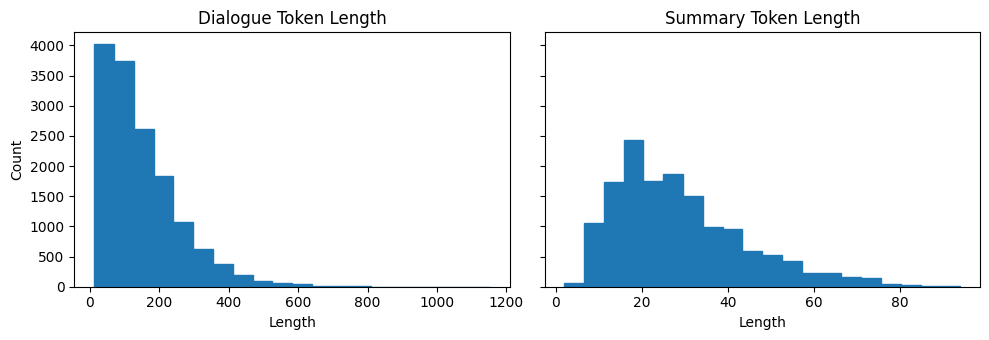

In [40]:
import matplotlib.pyplot as plt

# Calculate the token lengths for each dialogue in the training set
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]

# Calculate the token lengths for each summary in the training set
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

# Create a figure with two subplots (side by side) to compare dialogue and summary token lengths
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

# Plot a histogram for the dialogue token lengths
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")  # Using blue color for dialogue
axes[0].set_title("Dialogue Token Length")  # Title of the first subplot
axes[0].set_xlabel("Length")  # Label for the x-axis (length of tokens)
axes[0].set_ylabel("Count")  # Label for the y-axis (number of dialogues in each length range)

# Plot a histogram for the summary token lengths
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")  # Using blue color for summaries
axes[1].set_title("Summary Token Length")  # Title of the second subplot
axes[1].set_xlabel("Length")  # Label for the x-axis (length of tokens)

# Adjust layout to avoid overlap and make the plots clear
plt.tight_layout()

# Display the histograms
plt.show()

In [41]:
# Define a function to convert the examples in the dataset into features suitable for the model
def convert_examples_to_features(example_batch):
    # Tokenize the input dialogues, limit the length to 1024 tokens, and truncate if needed
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    # Tokenize the target summaries, limit the length to 128 tokens, and truncate if needed
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    # Return a dictionary of the tokenized inputs and target summaries
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

# Apply the convert_examples_to_features function to the entire dataset using the map function
# 'batched=True' ensures that the function processes multiple examples at once for efficiency
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)

# Define the columns to keep in the dataset in the PyTorch format: input_ids, labels, and attention_mask
columns = ["input_ids", "labels", "attention_mask"]

# Convert the dataset to the PyTorch format, with the specified columns for input and target
dataset_samsum_pt.set_format(type="torch", columns=columns)


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [42]:
# Importing the DataCollatorForSeq2Seq class from the transformers library
from transformers import DataCollatorForSeq2Seq

# Initializing the data collator for sequence-to-sequence tasks like summarization or translation.
# This collator will pad the input and target sequences and handle the batching process
# based on the tokenizer and model you are using.
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# The DataCollatorForSeq2Seq will:
# 1. Automatically pad the input sequences (like dialogues) and target sequences (like summaries)
#    to the maximum length in a batch, ensuring uniformity for model processing.
# 2. Truncate sequences that exceed the model's maximum allowable length.
# 3. Format the data to ensure the correct structure (e.g., input IDs, attention masks, labels) for the model.


### Feature Extraction

In [ ]:
### Fill you code ###

# Load a fresh T5-small model for layer-specific fine-tuning
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer

# Load the model
model_ckpt = "t5-small"
model_layerwise = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

# Step 1: Freeze all parameters
for param in model_layerwise.parameters():
    param.requires_grad = False

# Step 2: Unfreeze specific decoder layers
# We'll unfreeze the last 3 decoder blocks (blocks 3, 4, and 5)
# Each decoder block contains self-attention, cross-attention, and feed-forward layers
decoder_blocks_to_unfreeze = [3, 4, 5]

for block_idx in decoder_blocks_to_unfreeze:
    for param in model_layerwise.decoder.block[block_idx].parameters():
        param.requires_grad = True

# Also unfreeze the final layer norm of the decoder
for param in model_layerwise.decoder.final_layer_norm.parameters():
    param.requires_grad = True

# Step 3: Verify which parameters are trainable
print("Trainable parameters:")
trainable_params = 0
all_params = 0
for name, param in model_layerwise.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        print(f"  {name}")

print(f"\nTrainable params: {trainable_params:,} || All params: {all_params:,} || Trainable %: {100 * trainable_params / all_params:.2f}%")

# Step 4: Define training arguments for layer-specific fine-tuning
training_args_layerwise = TrainingArguments(
    output_dir='t5-layerwise',  # Directory to save model checkpoints
    num_train_epochs=10,  # Number of training epochs
    warmup_steps=500,  # Warmup steps before full learning rate
    per_device_train_batch_size=1,  # Batch size per device during training
    per_device_eval_batch_size=1,  # Batch size per device during evaluation
    weight_decay=0.01,  # Weight decay for regularization
    logging_steps=10,  # Log every 10 steps
    push_to_hub=False,  # Don't push to Hugging Face Hub
    evaluation_strategy='steps',  # Evaluate during training
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=1e6,  # Save checkpoint every 1M steps (effectively at end)
    gradient_accumulation_steps=16,  # Accumulate gradients over 16 steps
    report_to="none"  # Disable wandb logging
)

# Step 5: Initialize the Trainer
trainer_layerwise = Trainer(
    model=model_layerwise,  # The model with frozen/unfrozen layers
    args=training_args_layerwise,  # Training arguments
    tokenizer=tokenizer,  # Tokenizer
    data_collator=seq2seq_data_collator,  # Data collator for padding
    train_dataset=dataset_samsum_pt["train"],  # Training dataset
    eval_dataset=dataset_samsum_pt["validation"]  # Validation dataset
)

# Step 6: Train the model
print("\n" + "="*50)
print("Starting training with layer-specific fine-tuning...")
print("="*50 + "\n")
trainer_layerwise.train()

In [ ]:
# measure blue score

# Reload the BLEU metric for evaluation
bleu_metric = evaluate.load("bleu")

# Evaluate the fine-tuned model on the test set
print("Evaluating the layer-specific fine-tuned model...")
score_layerwise = evaluate_summaries_t5(
    dataset_samsum["test"], 
    bleu_metric, 
    trainer_layerwise.model,  # Use the trained model from trainer
    tokenizer,
    batch_size=8,  # Batch size for evaluation
    column_text="dialogue",  # Column name for input dialogues
    column_summary="summary"  # Column name for reference summaries
)

# Extract the BLEU score
bleu_score_layerwise = score_layerwise["bleu"]

# Create a DataFrame to display the results
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"BLEU Score (Layer-specific fine-tuning): {bleu_score_layerwise:.4f}")
print("="*50 + "\n")

# Create a comparison dataframe
import pandas as pd
results_df = pd.DataFrame({
    "Model": ["T5-small (Layer-specific)"],
    "BLEU": [bleu_score_layerwise]
})
display(results_df)

In [ ]:
#  generating Dialogue Summarie

# Import necessary modules
import transformers
from transformers import pipeline

# Set logging to error only to suppress warnings
transformers.logging.set_verbosity_error()

# Define generation parameters
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

# Create a summarization pipeline with the fine-tuned model
pipe_layerwise = pipeline("summarization", model=trainer_layerwise.model, tokenizer=tokenizer)

# Test on the first example from the test set
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

print("="*70)
print("DIALOGUE SUMMARY GENERATION - Layer-Specific Fine-tuned Model")
print("="*70)
print("\nDialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary (Layer-specific fine-tuning):")
print(pipe_layerwise(sample_text, **gen_kwargs)[0]["summary_text"])
print("="*70)

# Test on additional examples from the test set
print("\n" + "="*70)
print("ADDITIONAL TEST EXAMPLES")
print("="*70)

for i in range(1, 4):  # Test on 3 more examples
    sample_text = dataset_samsum["test"][i]["dialogue"]
    reference = dataset_samsum["test"][i]["summary"]
    
    print(f"\n--- Example {i+1} ---")
    print("\nDialogue:")
    print(sample_text[:300] + "..." if len(sample_text) > 300 else sample_text)
    print("\nReference Summary:")
    print(reference)
    print("\nModel Summary (Layer-specific fine-tuning):")
    print(pipe_layerwise(sample_text, **gen_kwargs)[0]["summary_text"])
    print("-" * 70)

# Test on a custom dialogue
print("\n" + "="*70)
print("CUSTOM DIALOGUE TEST")
print("="*70)

custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""

print("\nCustom Dialogue:")
print(custom_dialogue)
print("\nModel Summary (Layer-specific fine-tuning):")
print(pipe_layerwise(custom_dialogue, **gen_kwargs)[0]["summary_text"])
print("="*70)

### Fine Tuning (นิสิตไม่ต้องทำอะไรต่อจากนี้ ให้ไว้เพื่อดู code เป็นตัวอย่าง)

In [ ]:
# basicly you dont have to use this block if not publish your work to the hub
# otherwise if you are required to have some password in your code you can use this code block if needs
#import os

# Set your Hugging Face token
#os.environ["HUGGINGFACEHUB_API_TOKEN"] = "your token"
# Verify that the token is set
#print("Hugging Face Token:", os.getenv("HUGGINGFACEHUB_API_TOKEN") is not None)

Hugging Face Token: True


In [ ]:
# basicly you dont have to track your work for logging
# otherwise if your code cannot be run, feel free to use this bloxk for diable this loggging if needs
#import os

# Disable Weights & Biases
#os.environ['WANDB_DISABLED'] = 'true'

In [43]:
# Check if the parameters are frozen correctly
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

shared.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.q.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.k.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.v.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.o.weight: requires_grad=True
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight: requires_grad=True
encoder.block.0.layer.0.layer_norm.weight: requires_grad=True
encoder.block.0.layer.1.DenseReluDense.wi.weight: requires_grad=True
encoder.block.0.layer.1.DenseReluDense.wo.weight: requires_grad=True
encoder.block.0.layer.1.layer_norm.weight: requires_grad=True
encoder.block.1.layer.0.SelfAttention.q.weight: requires_grad=True
encoder.block.1.layer.0.SelfAttention.k.weight: requires_grad=True
encoder.block.1.layer.0.SelfAttention.v.weight: requires_grad=True
encoder.block.1.layer.0.SelfAttention.o.weight: requires_grad=True
encoder.block.1.layer.0.layer_norm.weight: requires_grad=True
encoder.block.1.l

In [48]:
from transformers import TrainingArguments, Trainer


# Defining the training arguments for model fine-tuning
training_args = TrainingArguments(
    output_dir='t5',  # Directory where the model and training logs will be saved
    num_train_epochs=10,  # Number of epochs to train the model
    warmup_steps=500,  # Number of warmup steps to perform before starting the actual training
    per_device_train_batch_size=1,  # Batch size for training (number of samples per batch during training)
    per_device_eval_batch_size=1,  # Batch size for evaluation (number of samples per batch during evaluation)
    weight_decay=0.01,  # Weight decay for regularization, helps prevent overfitting
    logging_steps=10,  # Logging frequency (steps at which to log training progress)
    push_to_hub=False,  # Disable pushing the model to the Hugging Face Hub after training
    #evaluation_strategy='steps',  # Define when to evaluate the model during training (evaluate every 'steps' steps)
    eval_steps=500,  # Number of steps between evaluations
    save_steps=1e6,  # Save model after every 1 million steps (or you can adjust this)
    gradient_accumulation_steps=16,  # Gradient accumulation steps for larger batch sizes, reduces memory usage during training
    report_to="none"  # Disables logging to WandB and other integrations
)


In [50]:
# Initializing the Trainer class to handle the training and evaluation process
trainer = Trainer(
    model=model,  # The pre-trained model to be fine-tuned
    args=training_args,  # The training arguments, including batch size, number of epochs, etc.
    tokenizer=tokenizer,  # The tokenizer to encode the input text for the model
    data_collator=seq2seq_data_collator,  # Data collator used to pad sequences dynamically during training
    train_dataset=dataset_samsum_pt["train"],  # The training dataset to be used for training
    eval_dataset=dataset_samsum_pt["validation"]  # The validation dataset to be used for evaluation
)

/tmp/ipykernel_37/3311845328.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

# Evaluate the model's performance using the T5 model and BLEU metric
score = evaluate_summaries_t5(
    dataset_samsum["test"], bleu_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary"
)

# Extract the BLEU score
bleu_score = score["bleu"]

# Create a dictionary to store the BLEU score for T5
bleu_dict = {"BLEU": bleu_score}

# Convert the score to a pandas DataFrame for better visualization
import pandas as pd
pd.DataFrame(bleu_dict, index=[f"T5"])

{'loss': 2.0541, 'grad_norm': 2.914802312850952, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.010860711376595167}
{'loss': 2.0893, 'grad_norm': 5.96926212310791, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.021721422753190334}
{'loss': 2.0626, 'grad_norm': 2.1943347454071045, 'learning_rate': 3e-06, 'epoch': 0.0325821341297855}
{'loss': 2.0248, 'grad_norm': 2.605330467224121, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04344284550638067}
{'loss': 1.9349, 'grad_norm': 2.9679934978485107, 'learning_rate': 5e-06, 'epoch': 0.054303556882975834}
{'loss': 1.9922, 'grad_norm': 3.1404731273651123, 'learning_rate': 6e-06, 'epoch': 0.065164268259571}
{'loss': 2.0248, 'grad_norm': 3.851630687713623, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.07602497963616617}
{'loss': 1.9781, 'grad_norm': 2.870978593826294, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.08688569101276133}
{'loss': 2.0196, 'grad_norm': 2.190049171447754, 'learning_rate': 9e-06, 'epoch': 0.09774640

100%|██████████| 410/410 [03:58<00:00,  1.72it/s]


,BLEU
T5,0.108711


### Generating Dialogue Summarie

In [ ]:
# Importing the necessary module from transformers
import transformers
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer

# Setting the logging level to suppress warnings, only show errors
transformers.logging.set_verbosity_error()

# Defining the generation parameters for the summarization model
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}

# Sample text from the dataset to summarize
sample_text = dataset_samsum["test"][0]["dialogue"]

# The reference summary for comparison
reference = dataset_samsum["test"][0]["summary"]

# Load the fine-tuned model and tokenizer from the specified checkpoint directory
checkpoint_dir = '/kaggle/working/t5/checkpoint-920'
model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)
tokenizer = T5Tokenizer.from_pretrained(checkpoint_dir)

# Initialize the summarization pipeline with the locally saved model
pipe = pipeline("summarization", model=model, tokenizer=tokenizer)

# Display the sample dialogue
print("Dialogue:")
print(sample_text)

# Display the reference summary
print("\nReference Summary:")
print(reference)

# Generate and display the summary using the model pipeline
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda has Betty's number. He called her last time we were at the park together. She'd rather Amanda text him .


In [ ]:
# Define a custom dialogue text for testing the summarization pipeline
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""

# Generate and display the summary for the custom dialogue
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Leandro and Lewis have heard of transformers recently. They have a great library by Hugging Face. They will write a book about it.
